In [1]:
from LeukemiaClassifier import *
import torch
import numpy as np
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def npy_loader(path):
    with open(path, 'r') as f:
        data = np.loadtxt(f)
    return data

In [12]:
dataset = DatasetFolder("./Processed_Embeddings_Reduced/", loader=npy_loader, extensions='.txt')

class_count = {}
for _, label in dataset:
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1

num_train = int(2000*0.6)
num_val = int(2000*0.2)
num_test = int(2000*0.2)

train_sampler = WeightedRandomSampler([0.25,0.25,0.25,0.25], num_train)
val_sampler = WeightedRandomSampler([0.25,0.25,0.25,0.25], num_val)
test_sampler = WeightedRandomSampler([0.25,0.25,0.25,0.25], num_val)

train_dataset, val_dataset, _ = random_split(dataset, [num_train, num_val, len(dataset) - num_train - num_val])

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
model = LeukemiaClassifier()
init_weights(model)
loss, tr_acc, vl_acc = train(model, train_loader, val_loader, initial_lr=0.1, epochs=50)

Training for 50 epochs using cuda...
Epoch 1 |	 Loss: 1.46 |	 Training Accuracy: 0.26 |	 Validation Accuracy: 0.20
Epoch 1 |	 Loss: 1.45 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 1 |	 Loss: 1.46 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 1 |	 Loss: 1.44 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 1 |	 Loss: 1.42 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 2 |	 Loss: 1.32 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 2 |	 Loss: 1.33 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 2 |	 Loss: 1.32 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 2 |	 Loss: 1.30 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 2 |	 Loss: 1.29 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 3 |	 Loss: 1.27 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 3 |	 Loss: 1.25 |	 Training Accuracy: 0.23 |	 Validation Accuracy: 0.28
Epoch 3 |	 Loss: 1.26 |	 Tr

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
def draw_confusion_matrix(predicted_labels, actual_labels):

    cm = confusion_matrix(actual_labels, predicted_labels)
    cm_df = pd.DataFrame(cm,
                     index = ['BENIGN','EARLY','PRE', 'PRO'], 
                     columns = ['BENIGN','EARLY', 'PRE', 'PRO'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix for Leukemia Classifier')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

def print_model_report(predicted_labels, actual_labels, class_names):
    print(classification_report(actual_labels, predicted_labels, target_names=class_names))

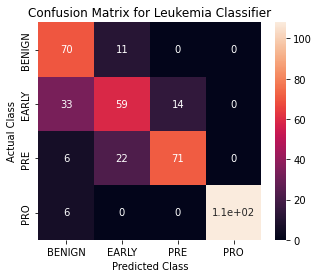

              precision    recall  f1-score   support

      BENIGN       0.61      0.86      0.71        81
       EARLY       0.64      0.56      0.60       106
         PRE       0.84      0.72      0.77        99
         PRO       1.00      0.95      0.97       114

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.76       400
weighted avg       0.78      0.77      0.77       400



In [7]:
model = model.cpu()
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
predicted_labels = np.array([])
actual_labels = np.array([])
for x, y in test_loader:
    predicted_labels = np.append(predicted_labels, model(x).argmax(dim=1).numpy())
    actual_labels = np.append(actual_labels, y.numpy())
class_names = ['BENIGN','EARLY', 'PRE', 'PRO']
draw_confusion_matrix(predicted_labels, actual_labels)
print_model_report(predicted_labels, actual_labels, class_names)

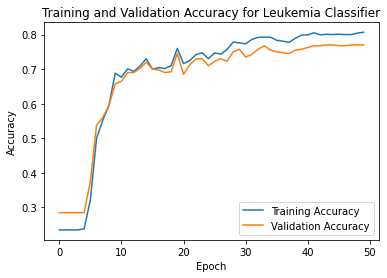

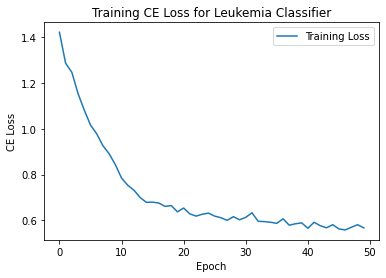

In [8]:
plt.figure(1)
plt.plot(tr_acc, label='Training Accuracy')
plt.plot(vl_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Leukemia Classifier')
plt.legend()

plt.figure(2)
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('CE Loss')
plt.title('Training CE Loss for Leukemia Classifier')
plt.legend()

In [9]:
arch = LeukemiaClassifier()
#load the state dictionary
arch.load_state_dict(torch.load('Trained_Model_Iteration_1'))
arch.eval()

LeukemiaClassifier(
  (upscale1): Linear(in_features=512, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (upscale2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (downscale1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (downscale2): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (downscale3): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=256, bias=True)
  (downscale4): Linear(in_features=256, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=64, bias=True)
  (downscale5): Linear(in_features=64, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=16, bias=True)
  (downscale6): Linear(in_features=16, out_features=4, bias=Tr

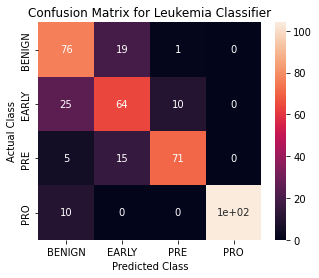

              precision    recall  f1-score   support

      BENIGN       0.66      0.79      0.72        96
       EARLY       0.65      0.65      0.65        99
         PRE       0.87      0.78      0.82        91
         PRO       1.00      0.91      0.95       114

    accuracy                           0.79       400
   macro avg       0.79      0.78      0.79       400
weighted avg       0.80      0.79      0.79       400



In [14]:
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
predicted_labels = np.array([])
actual_labels = np.array([])
for x, y in test_loader:
    predicted_labels = np.append(predicted_labels, arch(x).argmax(dim=1).numpy())
    actual_labels = np.append(actual_labels, y.numpy())
class_names = ['BENIGN','EARLY', 'PRE', 'PRO']
draw_confusion_matrix(predicted_labels, actual_labels)
print_model_report(predicted_labels, actual_labels, class_names)